# Multi-armed Bandits for Component Permutations

### Load Data

In [2]:
import os
import pandas as pd
import itertools
import seaborn
import math
from matplotlib import pyplot
from scipy import std, mean
from scipy.stats import mode, kurtosis, skew
from numpy import median
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import statistics
import pickle
from envs.data_handler import DataHandler

### Multi-armed Bandit

In [3]:
def lazy_property(fn):
    '''Decorator that makes a property lazy-evaluated.'''
    attr_name = '_lazy_' + fn.__name__

    @property
    def _lazy_property(self):
        if not hasattr(self, attr_name):
            setattr(self, attr_name, fn(self))
        return getattr(self, attr_name)
    return _lazy_property

class MultiArmedBandit:
    def __init__(self, no_of_actions=3, transform='raw', env='Linear'):
        dh = DataHandler(environment=env)
        self.__actions = dh.get_sample_component_failure_pairs(no_of_actions)
        self.__data = dh.data
        self.__arms = list(itertools.permutations(self.actions))
        self.__transform = transform
        
    @property
    def actions(self):
        return self.__actions
    
    @property
    def data(self):
        return self.__data
    
    @property
    def arms(self):
        return self.__arms
    
    @lazy_property
    def true_mean_action_rewards(self):
        mean_action_rewards = []
        for action in self.actions:
            action_data = self.data.loc[(self.data['Optimal_Affected_Component_Uid'] == action[0]) & 
                                   (self.data['Optimal_Failure'] == action[1])]
            mean_action_rewards.append(action_data[self.__transform].mean(axis=0))
        return mean_action_rewards
    
    @lazy_property
    def number_of_arms(self):
        return len(self.__arms)
    
    @lazy_property
    def true_mean_arm_rewards(self):
        rewards = []
        for arm_index in range(self.number_of_arms):
            rewards.append(self.true_mean_reward_for_arm(arm_index))
        return rewards
    
    @lazy_property
    def true_optimal_arm(self):
        # note that if there are several optimal arms, only the first is returned
        return self.true_mean_arm_rewards.index(max(self.true_mean_arm_rewards))
            
    
    def true_mean_reward_for_arm(self, arm_index=0):
        arm = self.arms[arm_index]
        total_time = len(arm)
        cumulative_reward = 0
        for action in arm:
            cumulative_reward += self.true_mean_action_rewards[self.actions.index(action)] * total_time
            total_time -= 1
        return cumulative_reward
    
    def pull_arm(self, arm_index=0):
        arm = self.arms[arm_index]
        total_time = len(arm)
        cumulative_reward = 0
        for action in arm:
            action_data = self.data.loc[(self.data['Optimal_Affected_Component_Uid'] == action[0]) & 
                                   (self.data['Optimal_Failure'] == action[1])]
            cumulative_reward += action_data.sample().iloc[0][self.__transform] * total_time
            total_time -= 1
        return cumulative_reward
    
    def reward_regret_optimal_for_arm(self, arm_index=0):
        reward = self.pull_arm(arm_index)
        optimal_reward = self.true_mean_arm_rewards[self.true_optimal_arm]
        regret = (optimal_reward - reward) / optimal_reward
        optimal = self.true_optimal_arm == arm_index
        return reward, regret, optimal
    
    def index_of_arm(self, arm):
        return self.arms.index(arm)
    


### Algorithms

In [4]:
class BanditAlgorithm:
    def __init__(self, bandit):
        self.__bandit = bandit
        self.__name = ''
    
    @property
    def bandit(self):
        return self.__bandit
    
    def reward_regret_optimal(self):
        pass

class EpsilonGreedy(BanditAlgorithm):
    def __init__(self, bandit, epsilon=0.3, decay=0.0):
        super().__init__(bandit)
        self.name = 'EpsilonGreedy'
        self.log = [[] for arm in self.bandit.arms]
        self.epsilon = epsilon
        self.decay = decay
    
    def log_is_empty(self):
        for entry in self.log:
            if entry: return False
        return True
    
    def reward_regret_optimal(self):
        arm = 0
        if random.random() <= self.epsilon or self.log_is_empty():
            arm = random.randrange(self.bandit.number_of_arms)
        else:
            means = [statistics.mean(entry) if entry else float('nan') for entry in self.log]
            arm = means.index(max(means))
        self.epsilon = self.epsilon * (1 - self.decay)
        reward, regret, optimal = self.bandit.reward_regret_optimal_for_arm(arm)
        self.log[arm].append(reward)
        return reward, regret, optimal

class UCBGreedy(BanditAlgorithm):
    def __init__(self, bandit, epsilon=0.3, decay=0.0):
        super().__init__(bandit)
        self.name = 'UCBGreedy'
        self.__log = [[] for arm in self.bandit.arms]
        self.__epsilon = epsilon
        self.__decay = decay
    
    def log_is_empty(self):
        for entry in self.__log:
            if entry: return False
        return True
    
    def reward_regret_optimal(self):
        arm = 0
        if random.random() <= self.__epsilon or self.log_is_empty():
            arm = random.randrange(self.bandit.number_of_arms)
        else:
            iteration = sum(len(x) for x in self.__log)
            means = [statistics.mean(entry) if entry else float('nan') for entry in self.__log]
            upper_confidence_bounds = [means[index] + math.sqrt((2*math.log(iteration+1))/len(self.__log[index])) if self.__log[index] else means[index] for index in range(len(means))]
            arm = upper_confidence_bounds.index(max(upper_confidence_bounds))
        self.__epsilon = self.__epsilon * (1 - self.__decay)
        reward, regret, optimal = self.bandit.reward_regret_optimal_for_arm(arm)
        self.__log[arm].append(reward)
        return reward, regret, optimal

### Simulator Class

In [35]:
class Simulator:
    def __init__(self, algorithms):
        self.__algorithms = algorithms
        self.__log = []
    
    def plot(self, value='regret'):
        pyplot.figure()
        pyplot.subplots(figsize=(20, 10))
        seaborn.lineplot(data=pd.DataFrame(self.__log), x='iteration', y=f'avg_{value}', hue='algorithm')
        pyplot.show()
        
    def simulate(self, iterations=1000, step_size=10):
        step_log = {algo: [] for algo in self.__algorithms}
        for i in range(iterations):
            for algo in self.__algorithms:
                step_log[algo].append(algo.reward_regret_optimal())
            if i % step_size == step_size - 1:
                for algo in self.__algorithms:
                    avg_reward = statistics.mean([result_tuple[0] for result_tuple in step_log[algo]])
                    avg_regret = statistics.mean([result_tuple[1] for result_tuple in step_log[algo]])
                    avg_optimal_arm_used = statistics.mean([result_tuple[2] for result_tuple in step_log[algo]])
                    log_entry = {'iteration': i+1, 'algorithm': algo.name, 'avg_reward': avg_reward, 'avg_regret': avg_regret, 'avg_optimal_arm_used': avg_optimal_arm_used}
                    self.__log.append(log_entry)
                step_log = {algo: [] for algo in self.__algorithms}

### Experiment

<Figure size 432x288 with 0 Axes>

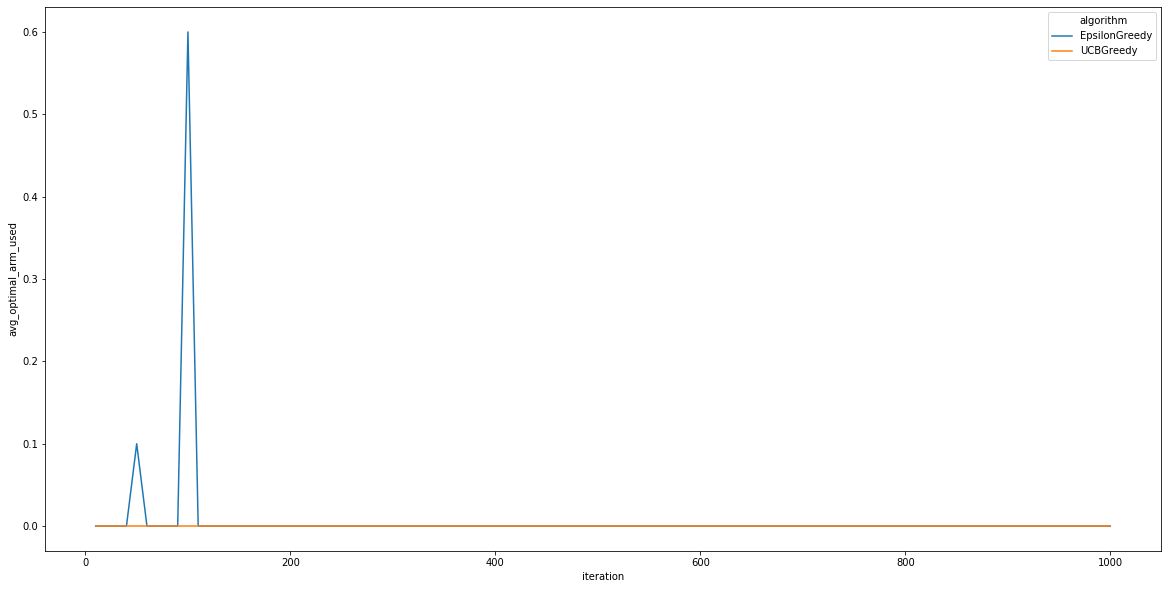

<Figure size 432x288 with 0 Axes>

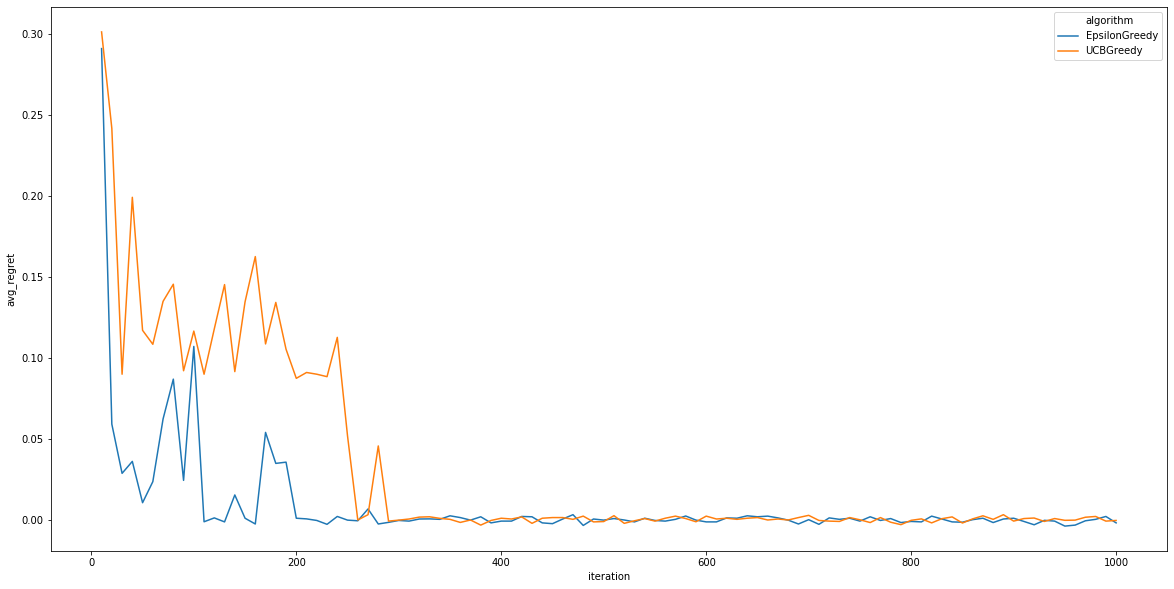

<Figure size 432x288 with 0 Axes>

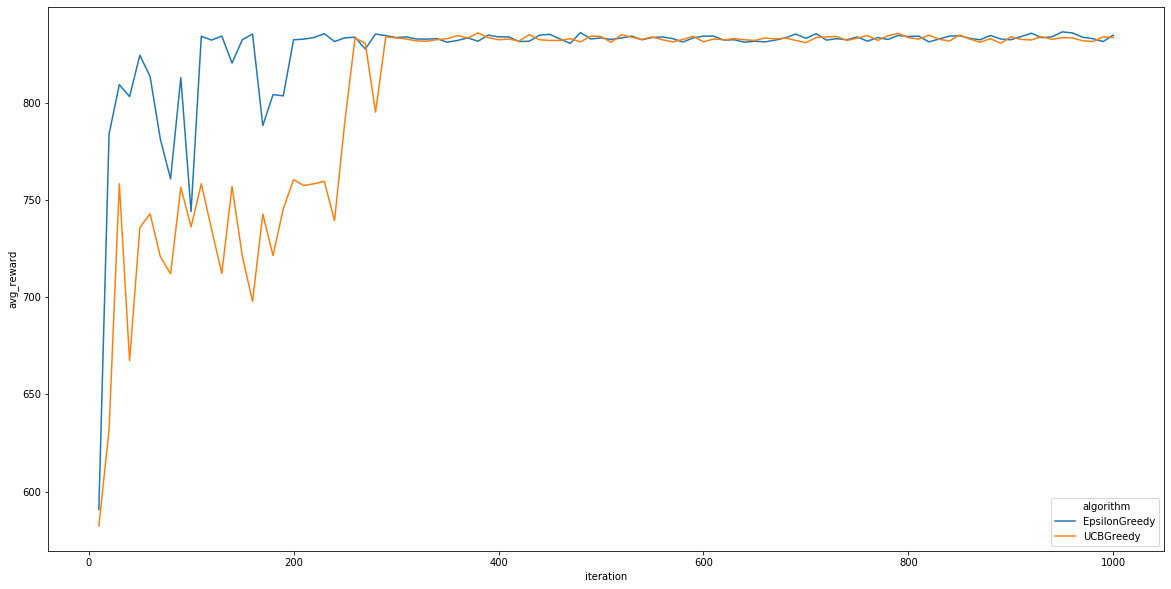

In [110]:
my_bandit = MultiArmedBandit(no_of_actions=4, transform='cube', env='Linear_Shifted')
algos = [EpsilonGreedy(my_bandit, epsilon=0.3, decay=0.01), UCBGreedy(my_bandit, epsilon=0.3, decay=0.01)]
sim = Simulator(algos)
sim.simulate(iterations=1000, step_size=10)
sim.plot('optimal_arm_used')
sim.plot('regret')
sim.plot('reward')

In [109]:
algos[1].reward_regret_optimal()

(160.47248854627418, 0.0, False)

### Old Bandit Statistics

In [ ]:
class MultiArmedGambler:
    def __init__(self, bandit):
        self.bandit = bandit
        
    def distribution(self, pulls_each=100 ):
        my_distr = []
        for arm_index in range(self.bandit.number_of_arms):
            my_distr.append(self.distribution_for_arm(arm_index, pulls_each))
        return my_distr
            
    def distribution_for_arm(self, arm_index, pulls=100):
        arm_distr = []
        for i in range(pulls):
            arm_distr.append(self.bandit.pull_arm(arm_index))
        return arm_distr
        
    def plot_arm(self, arm, pulls=100, bin_width=100):
        distribution = self.distribution_for_arm(arm, pulls)
        number_of_bins = math.ceil((max(distribution) - min(distribution)) / bin_width)
        pyplot.figure()
        pyplot.subplots(figsize=(20, 10))
        seaborn.distplot(distribution, number_of_bins, norm_hist=False)
        pyplot.show()
        stats = (f"Mean: {mean(distribution)}; "
                 f"Median: {median(distribution)}; "
                 f"Mode: {mode(distribution)[0][0]}; "
                 f"Standard Deviation: {std(distribution)}; "
                 f"kurtosis: {kurtosis(distribution)}; "
                 f"Skewness: {skew(distribution)}")
        print(stats)
    
    def plot_all_arms(self, pulls_each=100, bin_width=100):
        for arm in range(self.bandit.number_of_arms):
            self.plot_arm(arm, pulls_each, bin_width)
        
    def log(self):
        return {arm: [] for arm in self.bandit.arms}
    
    def __rmse(self, target, estimate):
        target = np.array([target]).flatten()
        estimate = np.array([estimate]).flatten()
        assert(len(target) == len(estimate))
        new_target = np.array([target[i] for i in range(len(target)) if not (math.isnan(target[i]) or math.isnan(estimate[i]))])
        new_estimate = np.array([estimate[i] for i in range(len(estimate)) if not (math.isnan(target[i]) or math.isnan(estimate[i]))])
        return np.sqrt(((new_target - new_estimate) **2).mean())
        
        
    def epsilon_greedy(self, epsilon=0.3, decay=0.0, stopping_rule=0.05, use_ucb=False, max_iterations=3000):
        params = {"epsilon": epsilon, "decay": decay, "stopping_rule": stopping_rule, "use_ucb": use_ucb, "max_iterations": max_iterations}
        random.seed()
        log = [[] for arm in self.bandit.arms]
        rmse_log = []
        optimal_arm = random.randrange(len(log))
        true_optimal_arm = self.bandit.true_optimal_arm
        log[optimal_arm].append(self.bandit.pull_arm(optimal_arm))
        iteration = 1
        means = [statistics.mean(entry) if entry else 0 for entry in log]
        upper_confidence_bounds = [means[index] + math.sqrt((2*math.log(iteration+1))/len(log[index])) if log[index] else means[index] for index in range(len(means))]
        
        def print_iteration():
            print(f"rmse: {rmse}")
            print(f"means: {means}")
            print(f"max mean: {max(means)}")
            print(f"true means: {self.bandit.true_mean_arm_rewards}")
            print(f"epsilon: {epsilon}")
            print(f"...iteration {iteration}")
            print("__________________________________________________")
        
        def plot_rmse():
            pyplot.figure()
            pyplot.subplots(figsize=(20, 10))
            seaborn.lineplot(data=pd.DataFrame(rmse_log), dashes=False)
            pyplot.show()
            print(f"True optimal arm: arm{true_optimal_arm} with true mean reward: {self.bandit.true_mean_arm_rewards[true_optimal_arm]}")
            print(f"Estimated optimal arm: arm{optimal_arm} with estimated mean reward: {np.array(log[optimal_arm]).mean()}")
        
        while ((iteration <= max_iterations) and self.__rmse(self.bandit.true_mean_arm_rewards, means) > stopping_rule * np.array(self.bandit.true_mean_arm_rewards).mean()):
            if random.random() <= epsilon:
                random_arm = random.randrange(len(log))
                log[random_arm].append(self.bandit.pull_arm(random_arm))
                print(f"chosen arm (random): arm{random_arm}")
            else:
                log[optimal_arm].append(self.bandit.pull_arm(optimal_arm))
                print(f"chosen arm (optimal): arm{optimal_arm}")
            means = [statistics.mean(entry) if entry else 0 for entry in log]
            upper_confidence_bounds = [means[index] + math.sqrt((2*math.log(iteration+1))/len(log[index])) if log[index] else means[index] for index in range(len(means))]
            optimal_arm = upper_confidence_bounds.index(max(upper_confidence_bounds)) if use_ucb else means.index(max(means))
            epsilon = epsilon * (1-decay)
            rmse = {f"Arm{arm_index}": (self.__rmse(self.bandit.true_mean_arm_rewards[arm_index], means[arm_index]) / self.bandit.true_mean_arm_rewards[arm_index]) for arm_index in range(len(log))}
            rmse["RMSE"] = self.__rmse(self.bandit.true_mean_arm_rewards, means) / np.array(self.bandit.true_mean_arm_rewards).mean()
            rmse_log.append(rmse)
            iteration += 1
            if iteration % 20 == 0:
                plot_rmse()
            print_iteration()
            
            
        plot_rmse()
        print_iteration()
        
        percentage_optimal_arm = len(log[self.bandit.true_optimal_arm])/iteration
        observed_reward = 0
        for arm_index in range(len(log)):
            observed_reward += self.bandit.true_mean_arm_rewards[arm_index] * len(log[arm_index])
        true_reward = self.bandit.true_mean_arm_rewards[self.bandit.true_optimal_arm] * iteration
        regret = true_reward - observed_reward
        average_regret = regret/iteration
        
        return {'iterations': iteration, 'rmse': rmse_log[-1]['RMSE'], 'reward': np.array(log).sum(), 'epsilon': epsilon, 'log': log, 'rmse_log':rmse_log, 'params': params, 'percentage_optimal_arm_used': percentage_optimal_arm, 'regret': regret, 'average regret': average_regret}
      


def evaluate_trial(trial, gambler):
    percentage_optimal_arm = len(trial['log'][gambler.bandit.true_optimal_arm])/trial['iterations']
    observed_reward = 0
    for arm_index in range(len(trial['log'])):
        observed_reward += gambler.bandit.true_mean_arm_rewards[arm_index] * len(trial['log'][arm_index])
    true_reward = gambler.bandit.true_mean_arm_rewards[gambler.bandit.true_optimal_arm] * trial['iterations']
    regret = true_reward - observed_reward
    average_regret = regret/trial['iterations']
    return {'percentage_optimal_arm_used': percentage_optimal_arm, 'regret': regret, 'average regret': average_regret}


three_actions = (('Query Service', 'CF1', 'RestartComponent'), 
                 ('Authentication Service', 'CF3', 'ReplaceComponent'), 
                 ('Reputation Service', 'CF5', 'AddReplica'))

actions = (('Query Service', 'CF1', 'RestartComponent'), 
          ('Authentication Service', 'CF3', 'ReplaceComponent'), 
          ('Reputation Service', 'CF5', 'AddReplica'), 
          ('Item Management Service', 'CF5', 'AddReplica'), 
          ('Last Second Sales Item Filter', 'CF2', 'RestartComponent'))
my_bandit = MultiArmedBandit(three_actions, data)
my_gambler = MultiArmedGambler(my_bandit)

### A Bit of Gambling

In [ ]:
my_gambler.plot_all_arms()

print(my_bandit.true_mean_arm_rewards)

In [ ]:
epsilon_greedy_trials = []
ucb_trials = []
hyperparams = [
    {'epsilon': 0.9, 'decay': 0.0, },
    {'epsilon': 0.9, 'decay': 0.001, },
    {'epsilon': 0.9, 'decay': 0.01, },
    {'epsilon': 0.6, 'decay': 0.0, },
    {'epsilon': 0.6, 'decay': 0.001, },
    {'epsilon': 0.6, 'decay': 0.01, },
    {'epsilon': 0.3, 'decay': 0.0, },
    {'epsilon': 0.3, 'decay': 0.001, },
    {'epsilon': 0.3, 'decay': 0.01, }
]
for params in hyperparams:
    ucb_trials.append(my_gambler.epsilon_greedy(epsilon=params['epsilon'], decay=params['decay'], use_ucb=True))
    
for params in hyperparams:
    epsilon_greedy_trials.append(my_gambler.epsilon_greedy(epsilon=params['epsilon'], decay=params['decay']))

In [ ]:
pickle.dump(ucb_trials, open('ucb_trials.p', 'wb'))
pickle.dump(epsilon_greedy_trials, open('epsilon_greedy_trials.p', 'wb'))